In [16]:
from sklearn.model_selection import train_test_split

import torch
import torch.nn.functional as F
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D
import torchvision
from torchvision import transforms as T
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import os
from tensorflow.keras.utils import to_categorical
import numpy as np
from sklearn.metrics import classification_report,  confusion_matrix, ConfusionMatrixDisplay
import sys
sys.path.append('../..')
from augmentation_generator_batch_size import *
from custom_transformers import *

In [17]:
def seed_everything(seed: int=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything(51)

## Load data

In [18]:
cifar10 = tf.keras.datasets.cifar10

(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
print(f"X_train.shape: {X_train.shape} \nY_train.shape: {Y_train.shape} \nX_test.shape: {X_test.shape} \nY_test.shape: {Y_test.shape}")

X_train.shape: (50000, 32, 32, 3) 
Y_train.shape: (50000, 1) 
X_test.shape: (10000, 32, 32, 3) 
Y_test.shape: (10000, 1)


## Random Square Cutout - without soft labeling

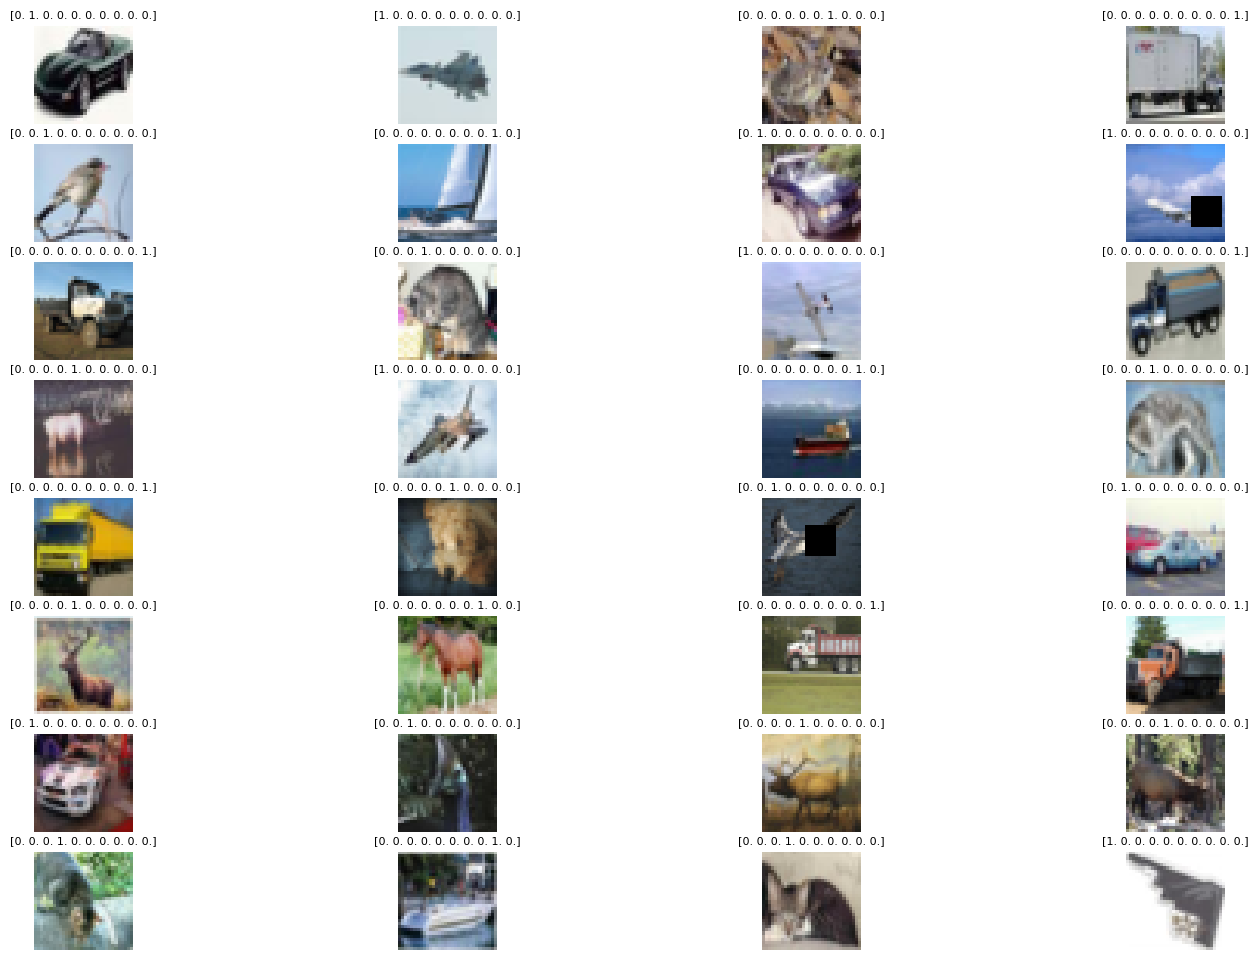

In [19]:
square_cutout = SquareCutout(size=10, color=False)
generator = AugmentedCIFAR10Generator(X_train, Y_train, batch_size=32, shuffle=True, augmentor= square_cutout, augment_fraction=0.2, overwrite=False, soft_label=False)

batch_x, batch_y = generator[0]

def denormalize(x):
    x = x.copy()
    x = np.clip(x * 255.0, 0, 255)
    return x.astype(np.uint8)

n = len(batch_x)
cols = 4
rows = n//cols + int(n%cols != 0)

fig, axes = plt.subplots(rows, cols, figsize=(18, 12))
if rows == 1 or cols == 1:
    axes = np.expand_dims(axes, axis=0)
for i in range(len(batch_x)):
    row = i // cols
    col = i % cols
    ax = axes[row, col]
    ax.imshow(denormalize(batch_x[i]))
    ax.set_title(batch_y[i], fontsize=8)
    ax.axis('off')

## CNN : Square size = 5
Without soft labels



In [20]:
square_cutout_5 = SquareCutout(size=5, color=False)

train_generator = AugmentedCIFAR10Generator(X_train, Y_train, batch_size=32, shuffle=True, augmentor=square_cutout_5, augment_fraction=0.2, num_classes=10, overwrite=False, soft_label=False)
test_generator = AugmentedCIFAR10Generator(X_test, Y_test, batch_size=32, augmentor=None)

In [21]:
k = 10
i = Input(shape=X_train[0].shape)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dropout(0.25)(x)

#hidden layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.25)(x)

#last hidden layer i.e.. output layer
x = Dense(k, activation='softmax')(x)

model = Model(i, x)

In [22]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

r = model.fit(
 train_generator, validation_data = test_generator, epochs=6)

Epoch 1/6


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - accuracy: 0.4461 - loss: 1.7340 - val_accuracy: 0.6542 - val_loss: 0.9742
Epoch 2/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.6952 - loss: 0.8744 - val_accuracy: 0.7271 - val_loss: 0.7836
Epoch 3/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.7673 - loss: 0.6790 - val_accuracy: 0.7674 - val_loss: 0.6842
Epoch 4/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8151 - loss: 0.5456 - val_accuracy: 0.7706 - val_loss: 0.6845
Epoch 5/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8475 - loss: 0.4482 - val_accuracy: 0.7983 - val_loss: 0.6212
Epoch 6/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8726 - loss: 0.3723 - val_accuracy: 0.8106 - val_loss: 0.6129


## Model statistics

In [23]:
y_pred = model.predict(test_generator, steps=len(test_generator), verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = np.argmax(test_generator.y_combined, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


Classification report

In [24]:
print(classification_report(y_true, y_pred_classes))

              precision    recall  f1-score   support

           0       0.10      0.09      0.10      1000
           1       0.12      0.11      0.11      1000
           2       0.11      0.08      0.09      1000
           3       0.08      0.08      0.08      1000
           4       0.09      0.10      0.10      1000
           5       0.11      0.12      0.11      1000
           6       0.09      0.11      0.10      1000
           7       0.11      0.12      0.11      1000
           8       0.10      0.10      0.10      1000
           9       0.09      0.09      0.09      1000

    accuracy                           0.10     10000
   macro avg       0.10      0.10      0.10     10000
weighted avg       0.10      0.10      0.10     10000



Confusion matrix

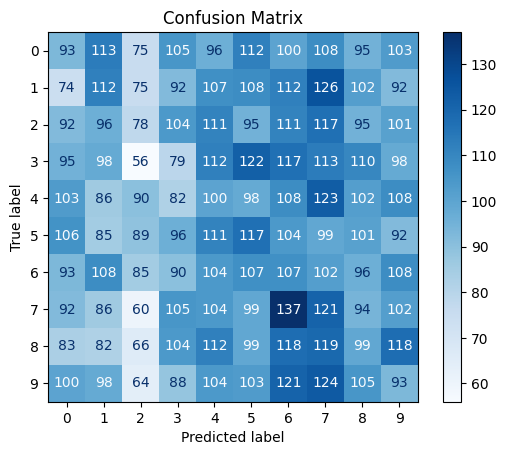

In [25]:
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

Accuracy

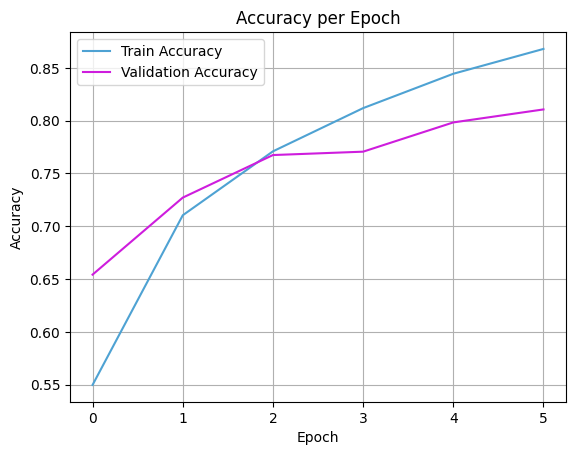

In [26]:
plt.plot(r.history['accuracy'], label='Train Accuracy', color = '#4ea2d3')
plt.plot(r.history['val_accuracy'], label='Validation Accuracy', color = '#ce1ddd')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
epochs = len(r.history['accuracy'])
plt.xticks(ticks=range(epochs))
plt.grid(True)
plt.show()

Final Val Acc : 0.81 </br>
Final Train Acc : 0.87

## CNN : Size = 10
without soft labels

In [27]:
square_cutout_10 = SquareCutout(size=10, color=False)

train_generator = AugmentedCIFAR10Generator(X_train, Y_train, batch_size=32, shuffle=True, augmentor=square_cutout_10, augment_fraction=0.2, num_classes=10, overwrite=False, soft_label=False)
test_generator = AugmentedCIFAR10Generator(X_test, Y_test, batch_size=32, augmentor=None)

In [28]:
k = 10
i = Input(shape=X_train[0].shape)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dropout(0.25)(x)

#hidden layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.25)(x)

#last hidden layer i.e.. output layer
x = Dense(k, activation='softmax')(x)

model = Model(i, x)

In [29]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

r = model.fit(
 train_generator, validation_data = test_generator, epochs=6)

Epoch 1/6


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - accuracy: 0.4499 - loss: 1.7557 - val_accuracy: 0.6783 - val_loss: 0.9242
Epoch 2/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.6937 - loss: 0.8726 - val_accuracy: 0.6669 - val_loss: 0.9894
Epoch 3/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.7574 - loss: 0.7055 - val_accuracy: 0.7741 - val_loss: 0.6712
Epoch 4/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8029 - loss: 0.5745 - val_accuracy: 0.7950 - val_loss: 0.6143
Epoch 5/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8388 - loss: 0.4733 - val_accuracy: 0.7843 - val_loss: 0.6845
Epoch 6/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8645 - loss: 0.3966 - val_accuracy: 0.8021 - val_loss: 0.6470


## Model statistics Size = 10

In [30]:
y_pred = model.predict(test_generator, steps=len(test_generator), verbose = 1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_generator.y_combined, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


In [31]:
print(classification_report(y_true, y_pred_classes))

              precision    recall  f1-score   support

           0       0.11      0.09      0.10      1000
           1       0.10      0.10      0.10      1000
           2       0.10      0.08      0.09      1000
           3       0.10      0.12      0.11      1000
           4       0.10      0.10      0.10      1000
           5       0.11      0.10      0.10      1000
           6       0.10      0.12      0.11      1000
           7       0.12      0.10      0.11      1000
           8       0.10      0.12      0.11      1000
           9       0.10      0.10      0.10      1000

    accuracy                           0.10     10000
   macro avg       0.10      0.10      0.10     10000
weighted avg       0.10      0.10      0.10     10000



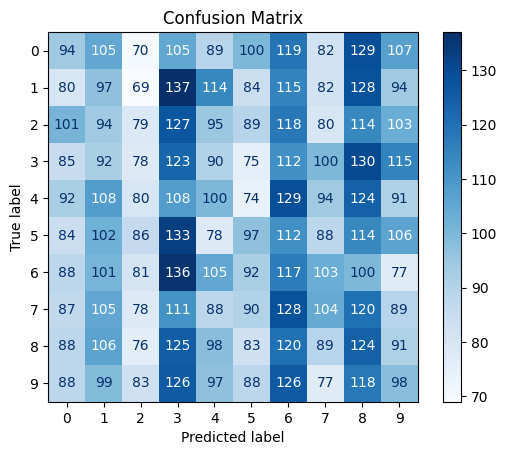

In [32]:
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

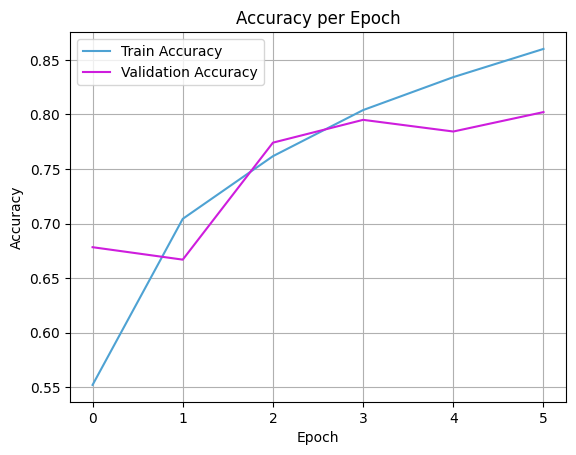

In [33]:
plt.plot(r.history['accuracy'], label='Train Accuracy', color = '#4ea2d3')
plt.plot(r.history['val_accuracy'], label='Validation Accuracy', color = '#ce1ddd')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
epochs = len(r.history['accuracy'])
plt.xticks(ticks=range(epochs))
plt.grid(True)
plt.show()

Final Val Acc : 0.80 </br>
Final Train Acc : 0.86